Final Project

Project Title: Sentiview — Real-Time Sentiment Analyzer

Group Members:

Emmanuel Osei (C0932615)

Gabriel Assiakwa (C0903299)

Millicent Cudjoe (C0934561)

Gopika Santhosh (C0934411)

Martha Kanyi (C0906214)

In [1]:
# Step 1 – Install Required Packages

!pip install scikit-learn pandas fastapi uvicorn pyngrok joblib

In [2]:
# Step 2 – Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [3]:
# Step 3 – Load Dataset
# Load dataset
df = pd.read_csv("/content/Amazon_Unlocked_Mobile.csv")

# Keep only relevant columns
df = df[['Reviews', 'Rating']].dropna()

# Map ratings to sentiment labels
def map_rating(r):
    if r <= 2:
        return 'negative'
    elif r == 3:
        return 'neutral'
    else:
        return 'positive'

df['label'] = df['Rating'].apply(map_rating)

# Keep only text and labels
df = df[['Reviews', 'label']]
print(df.head())


                                             Reviews     label
0  I feel so LUCKY to have found this used (phone...  positive
1  nice phone, nice up grade from my pantach revu...  positive
2                                       Very pleased  positive
3  It works good but it goes slow sometimes but i...  positive
4  Great phone to replace my lost phone. The only...  positive


In [4]:
# Step 4 – Preprocessing & Splitting
X_train, X_test, y_train, y_test = train_test_split(
    df['Reviews'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)


In [5]:
# Step 5 – Vectorization & Model Training
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=80000, min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_vec, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [6]:
# Step 6 – Evaluation
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.90      0.92      0.91     13582
     neutral       0.53      0.79      0.63      4311
    positive       0.98      0.92      0.95     38085

    accuracy                           0.91     55978
   macro avg       0.80      0.88      0.83     55978
weighted avg       0.93      0.91      0.91     55978

Confusion Matrix:
 [[12458   834   290]
 [  451  3413   447]
 [  892  2249 34944]]


In [7]:
# Step 7 – Save the Model
joblib.dump((vectorizer, model), "sentiment_model.pkl")


['sentiment_model.pkl']

In [8]:
# Step 8 – Simple API in Colab
%%writefile app.py
import joblib
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()

vectorizer, model = joblib.load("sentiment_model.pkl")

class TextIn(BaseModel):
    text: str

@app.post("/predict")
def predict(data: TextIn):
    vec = vectorizer.transform([data.text])
    proba = model.predict_proba(vec)[0]
    label = model.classes_[proba.argmax()]
    score = round(proba.max(), 4)
    return {"label": label, "confidence": score}

@app.get("/")
def root():
    return {"message": "Sentiment API is running"}


Writing app.py


Appendix - Visualizations

/tmp/ipython-input-754466648.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='coolwarm')


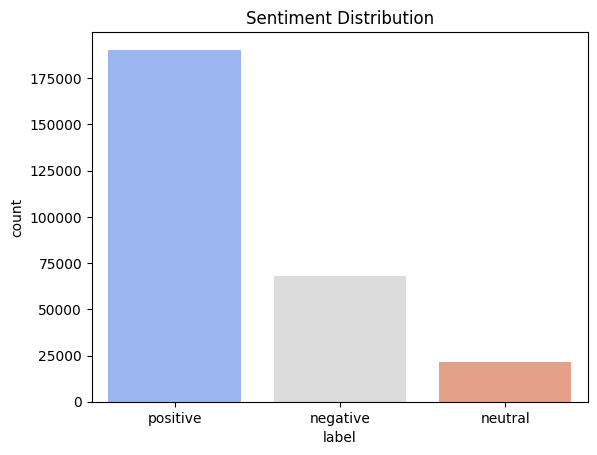

In [10]:
# 1. Sentiment Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['label'], palette='coolwarm')
plt.title("Sentiment Distribution")
plt.show()


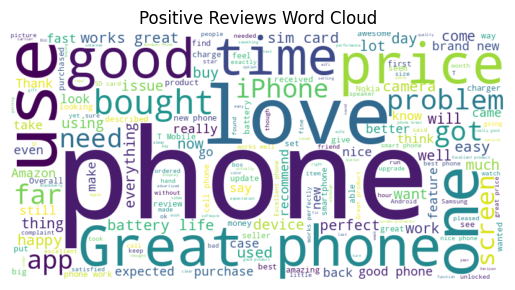

In [11]:
# 2. Word Cloud per Sentiment
from wordcloud import WordCloud

positive_text = " ".join(df[df['label']=='positive']['Reviews'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews Word Cloud")
plt.show()

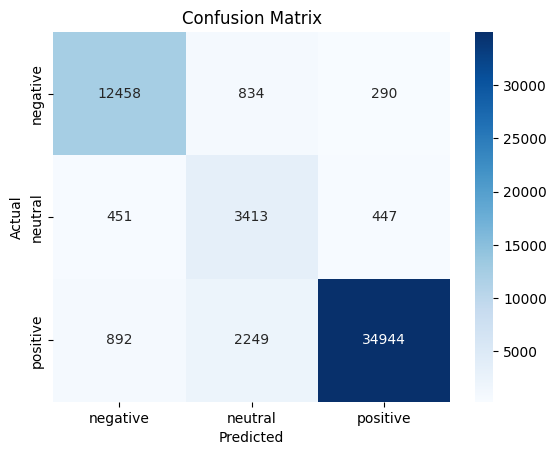

In [12]:
# 3. Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred, labels=['negative','neutral','positive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative','neutral','positive'], yticklabels=['negative','neutral','positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()


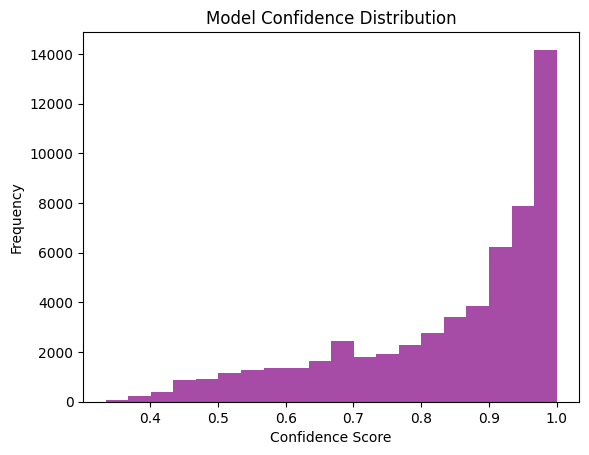

In [13]:
# 4. Sentiment Confidence Histogram
probs = model.predict_proba(X_test_vec).max(axis=1)
plt.hist(probs, bins=20, color='purple', alpha=0.7)
plt.title("Model Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()


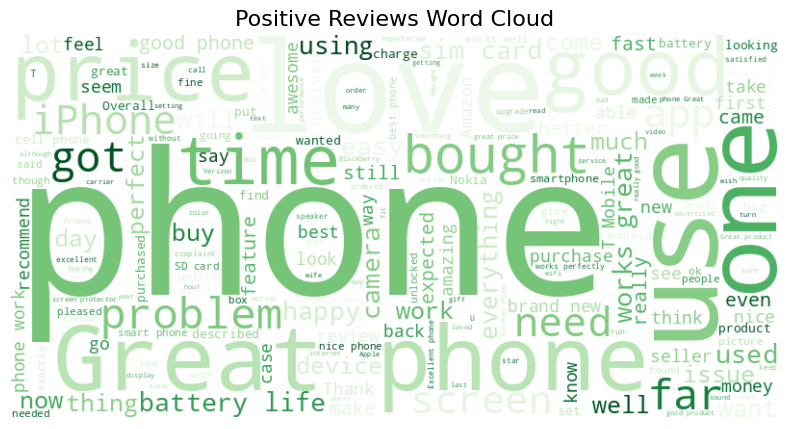

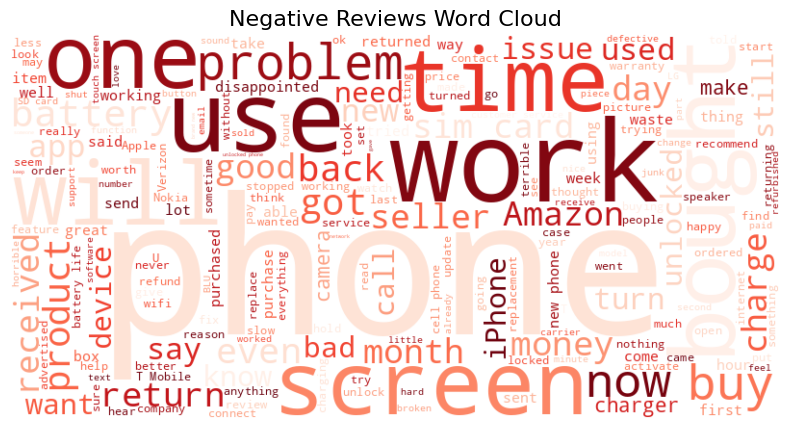

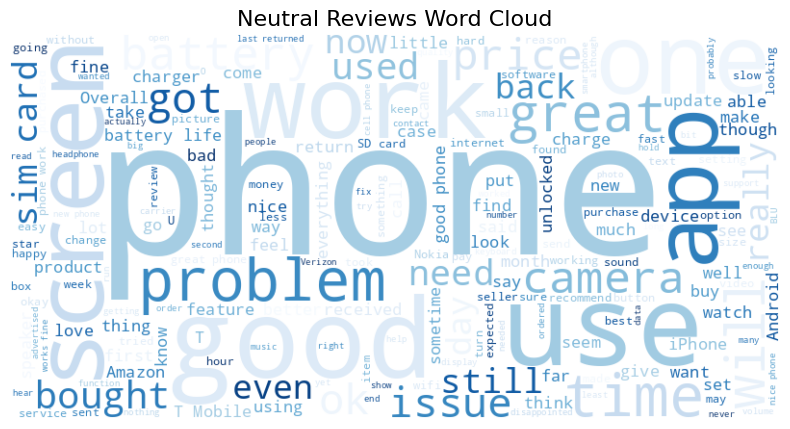

In [15]:

# The 'label' column is already created in a previous step, so this part is redundant.
# def simple_label(rating):
#     if rating >= 4:
#         return 'positive'
#     elif rating <= 2:
#         return 'negative'
#     else:
#         return 'neutral'

# df['label'] = df['Rating'].apply(simple_label)

# Function to create word cloud
def plot_wordcloud(sentiment_label, color):
    text = " ".join(df[df['label'] == sentiment_label]['Reviews'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment_label.capitalize()} Reviews Word Cloud", fontsize=16)
    plt.show()

# Plot all three
plot_wordcloud('positive', 'Greens')
plot_wordcloud('negative', 'Reds')
plot_wordcloud('neutral', 'Blues')